Using TensorFlow backend.
tr_error : 19404582468941668.000000, reg : 3.1346364e+01, te_error : 2.000000 :   0%|          | 3/1999 [00:00<01:16, 26.19it/s]        

SGLD_500


tr_error : 15683291310.722179, reg : 1.7651154e+02, te_error : 3134484.228488 :  20%|██        | 405/1999 [00:14<00:56, 28.17it/s]                               

tr_error : 33934051.516125, reg : 2.5424599e+02, te_error : 547876.606304 :  40%|████      | 804/1999 [00:27<00:42, 28.44it/s]                                   

tr_error : 139102034680.151794, reg : 3.3398480e+02, te_error : 5898687398.754779 :  60%|██████    | 1206/1999 [00:41<00:27, 28.92it/s]                             

tr_error : 17642991.196066, reg : 3.5554346e+02, te_error : 6087090.982494 :  80%|████████  | 1604/1999 [00:55<00:13, 28.95it/s]                                 

tr_error : 81075733.856962, reg : 3.6619422e+02, te_error : 84587321.528301 : 100%|██████████| 1999/1999 [01:08<00:00, 29.23it/s]                                     


SGHMC


tr_error : 4.147107, reg : 2.3933638e+01, te_error : 2.812949 :  20%|██        | 404/1999 [00:21<01:26, 18.50it/s]

tr_error : 5.742994, reg : 4.2961016e+01, te_error : 3.698217 :  40%|████      | 804/1999 [00:42<01:04, 18.49it/s]

tr_error : 8.496720, reg : 5.9261621e+01, te_error : 4.577667 :  60%|██████    | 1203/1999 [01:03<00:44, 18.08it/s]

tr_error : 7.304567, reg : 7.3967938e+01, te_error : 6.395710 :  80%|████████  | 1604/1999 [01:24<00:21, 18.16it/s] 

tr_error : 7.045995, reg : 8.8038551e+01, te_error : 5.611829 : 100%|██████████| 1999/1999 [01:45<00:00, 18.89it/s] 


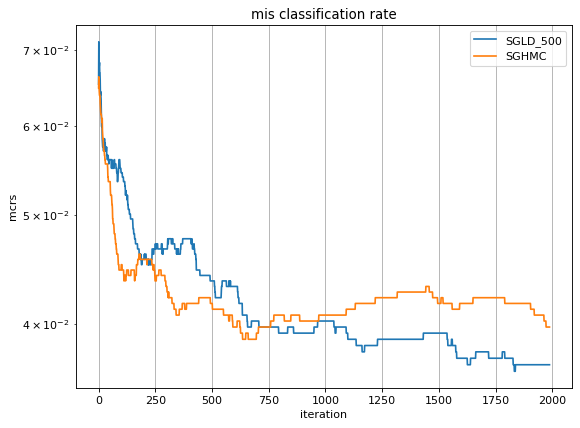

In [1]:
import sys
sys.path.append('..')

from sgmcmc.cores.data import *
from sgmcmc.cores.utils import *
from sgmcmc.cores.loss import *
from sgmcmc.cores.algo import SGLD, SGHMC
from sgmcmc.cores.initialize import *

%matplotlib inline

# Example Setting
params = {
    "data_name": DataMNIST,
    "seed": 200,
    "reg": 1.,
    "tau": 0,
    "stepsize": 5e-4,
    "max_iter": 2000,
    "a": 0.1,
    "b": 0.9,
    "init_method": init_rand_normal,
    "alpha": 1.,
    "is_mcr": True,
    "is_numgrad": False,
    "is_save": True,
    "batch": 500,
}

plots = [
    {"ylabel": "mcrs", "xlabel": "iteration",
     "yscale":"log", "title": "mis classification rate", "xlim": False},
]

file_name = []
for key, val in params.items():
    if key == "init_method":
        val = val.__name__
        file_name.append(val)
    if key in ["seed", "reg", "stepsize", "max_iter"]:
        file_name.append(key)
        file_name.append(str(val))
file_name = params['data_name'].__name__+'_'+'_'.join(file_name)

funcs = (func_lr_2c,  grad_lr_2c, None)

mcmc_algorithms = [
    ("SGLD_500", "+", SGLD(linesearch=constantstep, max_iter=params['max_iter'], batch=params['batch'],
                       reg=params['reg'], stepsize=params['stepsize'], info='SGLD')),
    ("SGHMC", "*", SGHMC(linesearch=constantstep, max_iter=params['max_iter'], batch=params['batch'],
                         reg=params['reg'],stepsize=params['stepsize'], info='SGHMC')),
]

dataset = params['data_name']
data = dataset.load_data()

results = []
for name, marker, algorithm in mcmc_algorithms:
    print(f'{name}')
    res = algorithm.solve(data=data, funcs=funcs)
    res["marker"] = marker
    res["name"]=name
    if params["is_mcr"]:
        res["mcrs"] = mcr_posterior(data['test'], res['betas'])
    if params["is_numgrad"]:
        res["num_grad"] = algorithm.num_grad(data['train'])
    results.append(res)

# collect results
outputs = {'tr_errors': [res['tr_errors'] for res in results],
           'te_errors': [res['te_errors'] for res in results],
           'times': [res['times'] for res in results],
           'names': [res['name'] for res in results],
           'markers': [res['marker'] for res in results],
           'is_save': params['is_save']}
if params["is_mcr"]:
    outputs['mcrs'] = [res['mcrs'] for res in results]
if params["is_numgrad"]:
    outputs['num_grads'] = [res['num_grad'] for res in results]

# plot results
for plot in plots:
    plotresult(plot, outputs, file_name)